 Business Case 1: Segmenting Clients
In the file Dataset1_BankClients.xls we have a random extraction of a (real-world) dataset made up of a bank's customers. The data is anonymous, mostly clean and normalized in [0, 1].

The aim of this Business Case is to segment these customers using Data Science techniques (mainly Unsupervised Machine Learning); this is a segmentation carried out from the perspective of the financial services sector.

### Read Data

In the following section we read the data from the excell file and proceed by loading it in matrix form

In [1]:
import pandas as pd

# Select the right path, if colab use google library to import the file from the drive
# path = 'C:/Users/giaco/Documents/GitHub/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'
path = 'C:\\Matteo\\0001_LM_SECONDOSEMESTRE\\FINANCIAL ENGINEERING\\ASSIGNMENTS FE\\LAB EPFL\\BC_1\\Dataset1_BankClients.xlsx'
# path = 'C:/Users/nicol/GitHub_Nick/Fintech_group13/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'

# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Colab Notebooks/FINTECH/BUSINESS_CASES_FINTECH/Zenti_Business_Case_1/Dataset1_BankClients.xlsx'

# Load data in a DataFrame
data = pd.read_excel(path)

# Let's inspect the first 5 record
print(data.head())
# Drop the column by its actual name (e.g., 'ID' or the actual name of the column)
data = data.drop(columns=['ID'])  # Replace 'ID' with the actual column name to drop

   ID  Age  Gender  Job  Area  CitySize  FamilySize    Income    Wealth  \
0   1   24       1    1     2         2           4  0.668046  0.702786   
1   2   47       1    2     2         3           1  0.858453  0.915043   
2   3   38       0    2     1         2           2  0.926818  0.898316   
3   4   67       0    2     1         2           3  0.538797  0.423180   
4   5   33       0    2     1         3           1  0.806659  0.731404   

       Debt    FinEdu       ESG   Digital  BankFriend  LifeStyle    Luxury  \
0  0.262070  0.741853  0.483684  0.698625    0.618259   0.607877  0.897369   
1  0.730430  0.859423  0.537167  0.959025    0.785936   0.862271  0.913729   
2  0.441272  0.485953  0.649434  0.750265    0.699725   0.755404  0.765199   
3  0.600401  0.493144  0.533829  0.590165    0.675353   0.334432  0.517209   
4  0.831449  0.856286  0.784940  0.710026    0.758793   0.908878  0.611610   

     Saving  Investments  
0  0.283222            1  
1  0.821590            3  

### Exploratory Data Analysis (EDA)
Correlation Analysis

We start by evaluating the correlation among the features of the dataset. Even if collinearity does not create problems in Machine Learning algorithms, the study of correlation is a good practice to investigate our dataset.

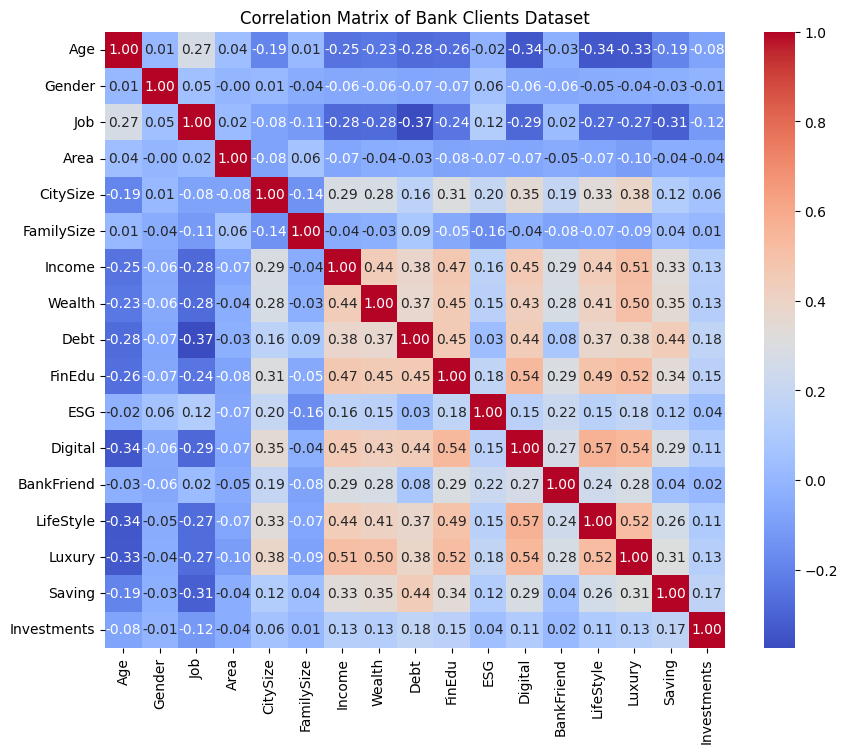

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Bank Clients Dataset')
plt.show()


Overall, the features exhibit limited correlation. The strongest correlation observed is between Digital and Lifestyle features. Maintaining these features as separate entities is recommended, as they may represent distinct customer personas.

### Preparing data

We extract the variables of interest, also dividing into:

Numerical: Age, FamilySize, Income, Wealth, Debt, FinEdu, ESG, Digital, BankFriend, LifeStyle, Luxury, Saving.

Categorical: Gender, Job, Area, CitySize, Investments (excluding the ID, which is not informative at this level).

We have to:

- Encode categorical variables, so that they can be digestible by clustering algorithms - they are all trasformed in boolean variables by one-hot encoding.
\
- Normalize in [0, 1] numerical variables.

In [3]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np

# Specify categorical variables
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']

# Split variables
numerical_features = data.drop(columns=categorical_columns)  # Exclude categorical variables
categorical_features = data[categorical_columns]  # Select categorical variables

# Convert categorical in typ 'category' (for OneHotEncoder)
categorical_features = categorical_features.astype('category')

# Normalize numerical variables
scaler = MinMaxScaler()
X_num = scaler.fit_transform(numerical_features)

# One-hot encoding categorical variables
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')  # Dummy encoding - ignoring unknwown values
X_cat = encoder.fit_transform(categorical_features).toarray()  # Convert into a dense matrix

# Concatenation of numerical and categorical variables
X = np.hstack((X_num, X_cat))

In [4]:
# Summary of the dataset
print("Numerical Features Shape:", X_num.shape)
print("Categorical Features Shape:", X_cat.shape)
print("Combined Features Shape:", X.shape)

Numerical Features Shape: (5000, 12)
Categorical Features Shape: (5000, 11)
Combined Features Shape: (5000, 23)


### Selection of the distance

We investigate different distances and try to combine them to obtain better result, enanching the difference between categorical and numerical features.

We start by considering the gower distance, and compute the distance matrix.

Moreover, we define the functions to plot and compute the customized distance.

In [5]:
import gower

# Calculate the Gower distance matrix
gower_distances = gower.gower_matrix(X)

In [6]:
from sklearn.manifold import TSNE
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
import gower
from scipy.spatial.distance import cdist

# Function to perform t-SNE with specified distance and display the result
def plot_tsne(X, metric, title, subplot_position):
    # Changed 'pca' to 'random' for precomputed distance
    random_state = 42
    tsne = TSNE(learning_rate='auto', init='random', random_state=random_state, metric=metric)
    Y = tsne.fit_transform(X)
    plt.subplot(2, 2, subplot_position)
    plt.scatter(Y[:, 0], Y[:, 1], c='blue', alpha=0.6)
    plt.title(title)
    plt.grid(True, alpha=0.3)

### Custom Distance: Numerical + Categorical

This function computes a combined distance matrix by applying separate metrics for numerical and categorical features, then weighting and merging these distances into a single result.

- **Parameters**:
  - **X_num** (*np.ndarray*):  
    A matrix of shape (n x d_num) containing the numerical features (already scaled).
  - **X_cat** (*np.ndarray*):  
    A matrix of shape (n x d_cat) containing the categorical features (one-hot encoded).
  - **w_num** (*float*):  
    A weight in the range (0, 1) that scales the contribution of the numerical distance.
  - **distance_num** (*str*):  
    The metric to be used for the numerical part (e.g., `'cityblock'`, `'euclidean'`, `'cosine'`).
  - **distance_cat** (*str*):  
    The metric to be used for the categorical part (e.g., `'rogerstanimoto'`, `'hamming'`, `'jaccard'`).

- **Returns**:
  - **dist_matrix** (*np.ndarray*):  
    The resulting NxN matrix of combined distances.


In [7]:
# Function to compute a customized distance: L1+rogerstanimoto
def compute_custom_distance(
    X_num: np.ndarray,
    X_cat: np.ndarray,
    w_num: float = 0.5,
    distance_num: str = 'cityblock',
    distance_cat: str = 'hamming'
) -> np.ndarray:
    
    # Numerical distance NxN
    dist_num = cdist(X_num, X_num, metric=distance_num)

    # Categorical distance NxN
    dist_cat = cdist(X_cat, X_cat, metric=distance_cat)

    # Weighted linear combination
    dist_matrix = w_num * dist_num + (1.0 - w_num) * dist_cat
    return dist_matrix

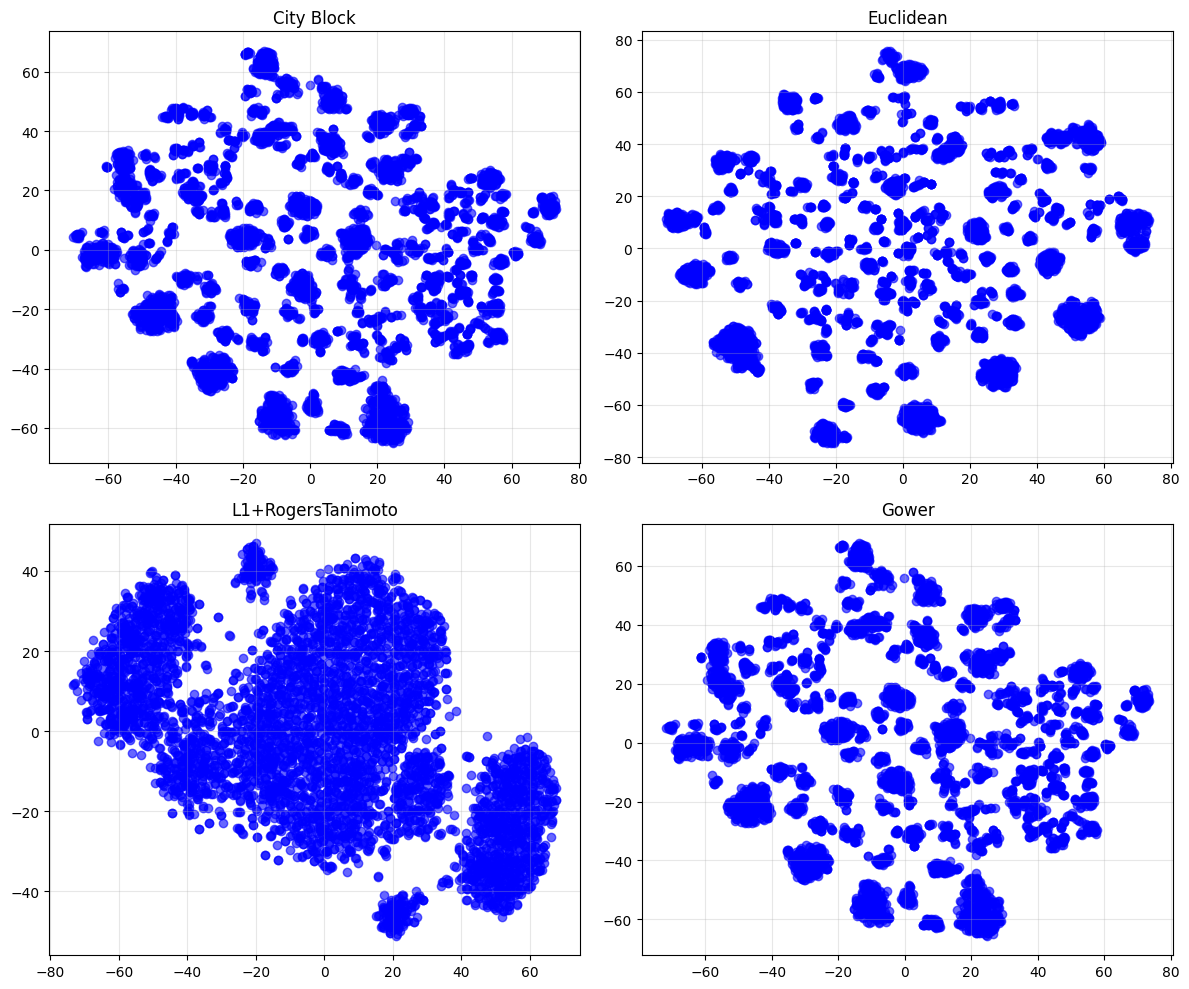

In [8]:
# X is already defined - see above

# For reproducibility
random_state = check_random_state(42)

# Let's try different metrics and see what happens
# Create chart
plt.figure(figsize=(12, 10))

# t-SNE with distance = 'cityblock'
plot_tsne(X, metric='cityblock', title='City Block', subplot_position=1)

# # t-SNE with distance = 'cosine'
# plot_tsne(X, metric='cosine', title='Cosine', subplot_position=2)

# # t-SNE with distance = 'euclidean'
plot_tsne(X, metric='euclidean', title='Euclidean', subplot_position=2)

# t-SNE with distance = L1+rogerstanimoto
L1rog_distances = compute_custom_distance(
    X_num,
    X_cat,
    w_num = 0.5,
    distance_num = 'cityblock',
    distance_cat = 'rogerstanimoto' # 'rogerstanimoto' is the same as 'jaccard' for binary data
    # distance_cat = 'jaccard'
    # distance_cat = 'hamming'
)

plot_tsne(L1rog_distances, metric='precomputed', title='L1+RogersTanimoto', subplot_position=3)

# t-SNE with distance = 'Gower'
plot_tsne(gower_distances, metric='precomputed', title='Gower', subplot_position=4)

# Show everything
plt.tight_layout()
plt.show()

3D plot

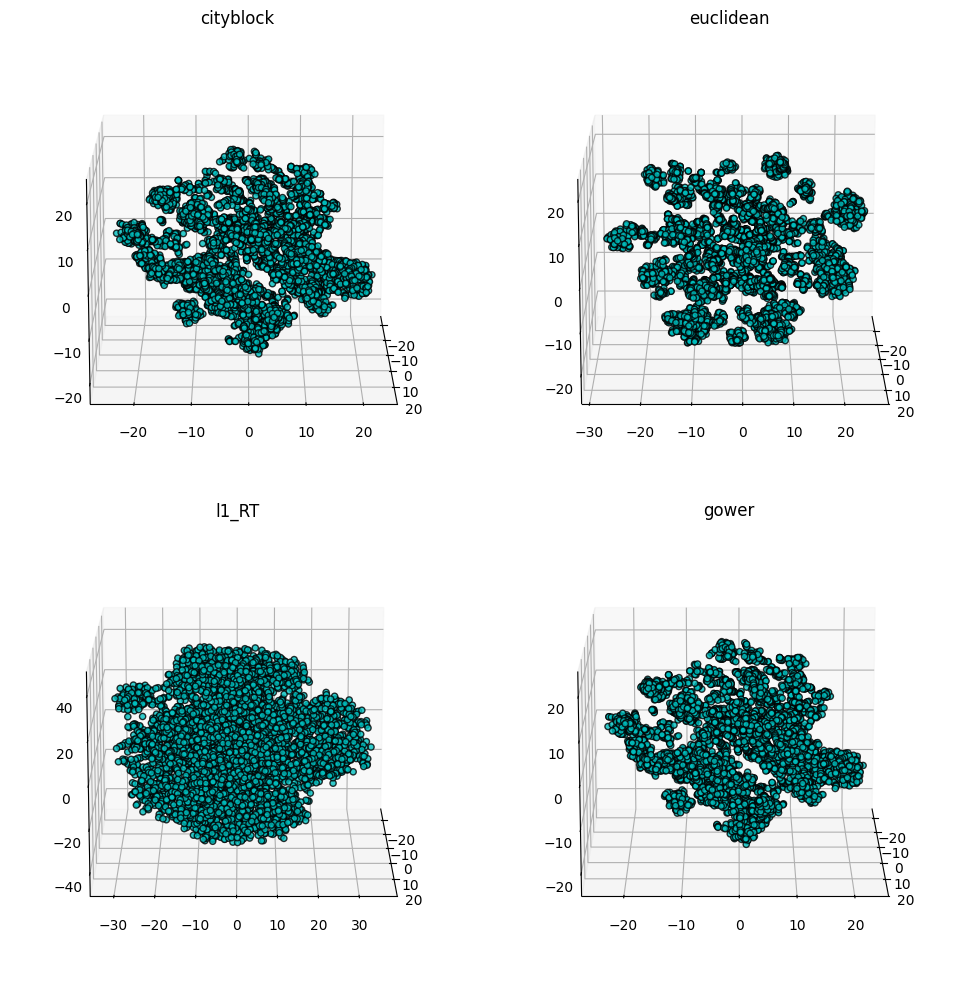

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# plt.figure(figsize=(10, 8))
# plt.grid(True, alpha=0.3)
metrics = ['cityblock','euclidean','l1_RT','gower']

# Assuming X and weights are defined elsewhere
num_plots = len(metrics)  # Number of different weight settings
cols = min(2, num_plots)  # Number of columns in the subplot grid
rows = (num_plots + cols - 1) // cols  # Determine the number of rows

fig = plt.figure(figsize=(5 * cols, 5 * rows))
# Iterate over the different metrics
for i, m in enumerate(metrics):

  if m == 'gower':
    # t-SNE, Gower, 3-D
    tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
    Y_3d = tsne.fit_transform(gower_distances)
  elif m == 'l1_RT':
    # t-SNE, L1 rog, 3-D
    tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
    Y_3d = tsne.fit_transform(L1rog_distances)
  else:
    # t-SNE, general case, 3-D
    tsne = TSNE(n_components=3, metric=m, random_state=42, init='random')
    Y_3d = tsne.fit_transform(X)


  # Visualize 3-D
  # Create subplot

  ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

  ax.scatter(Y_3d[:, 0], Y_3d[:, 1], Y_3d[:, 2],
              edgecolor='k', facecolor=(0, 0.75, 0.75), alpha=0.8)

  ax.set_title(m, fontsize=12)
  ax.view_init(elev=15, azim=0)
  # ax.view_init(elev=25, azim=10)

# Show everything
plt.tight_layout()
plt.show()


In [10]:
import plotly.express as px

# t-SNE, Gower, 3-D
tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
Y_3d = tsne.fit_transform(gower_distances)

# Visualize 3-D
fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:,1], z=Y_3d[:,2])
fig.update_traces(marker = dict(size=2))
fig.update_layout()
fig.show()

In [11]:
import plotly.express as px

# t-SNE, L1 rog, 3-D
tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
Y_3d = tsne.fit_transform(L1rog_distances)

# Visualize 3-D
fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:,1], z=Y_3d[:,2])
fig.update_traces(marker = dict(size=2))
fig.update_layout()
fig.show()



Qualitative weights exploration

1. We set a vector of weights for the features based on the relative importance in the businsess scenario, and apply them to the distance matrix of the gower metric

2. Set different weights between categorical and numerical features on the combined distance

In [12]:
# weights = np.array([[4, 4, 10, 10, 10, 7, 5, 10, 5, 4, 10, 9, 4, 6, 6, 6, 6, 8, 8, 6, 6, 9, 9]/np.sum(np.array([4, 4, 10, 10, 10, 7, 5, 10, 5, 4, 10, 9, 4, 6, 6, 6, 6, 8, 8, 6, 6, 9, 9])),
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]/np.sum(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]/np.sum(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
#                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]/np.sum(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))])

# weights = np.array([[3, 2, 5, 5, 5, 4, 2, 5, 3, 2, 5, 5, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]/np.sum(np.array([3, 2, 5, 5, 5, 4, 2, 5, 3, 2, 5, 5, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])),
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]/np.sum(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]/np.sum(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
#                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]/np.sum(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))])

weights = np.array([[8, 7, 10, 10, 10, 9, 7, 10, 8, 7, 10, 10, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]/np.sum(np.array([8, 7, 10, 10, 10, 9, 7, 10, 8, 7, 10, 10, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])),
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]/np.sum(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])),
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]/np.sum(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])),
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]/np.sum(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))])

titles = ['Arbitrary Weights', 'Equal Weights', 'Only Numerical', 'Only Categorical']

# plt.figure(figsize=(12, 10))
# plt.grid(True, alpha=0.3)

for i, w in enumerate(weights):
  # Calculate the Gower distance matrix
  gower_distances_temp = gower.gower_matrix(X, weight=w)

  # # t-SNE with distance = 'Gower'
  # tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
  # Y_gower = tsne.fit_transform(gower_distances_temp)

  # t-SNE, Gower, 3-D
  tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
  Y_3d = tsne.fit_transform(gower_distances_temp)

  # Visualize 3-D
  fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:,1], z=Y_3d[:,2])
  fig.update_traces(marker = dict(size=2))
  fig.update_layout()
  fig.show()

  # plt.subplot(2, 2, i+1)
  # plt.scatter(Y_gower[:, 0], Y_gower[:, 1], c='blue', alpha=0.6)
  # plt.title(titles[i])

# Show everything
# plt.tight_layout()
# plt.show()



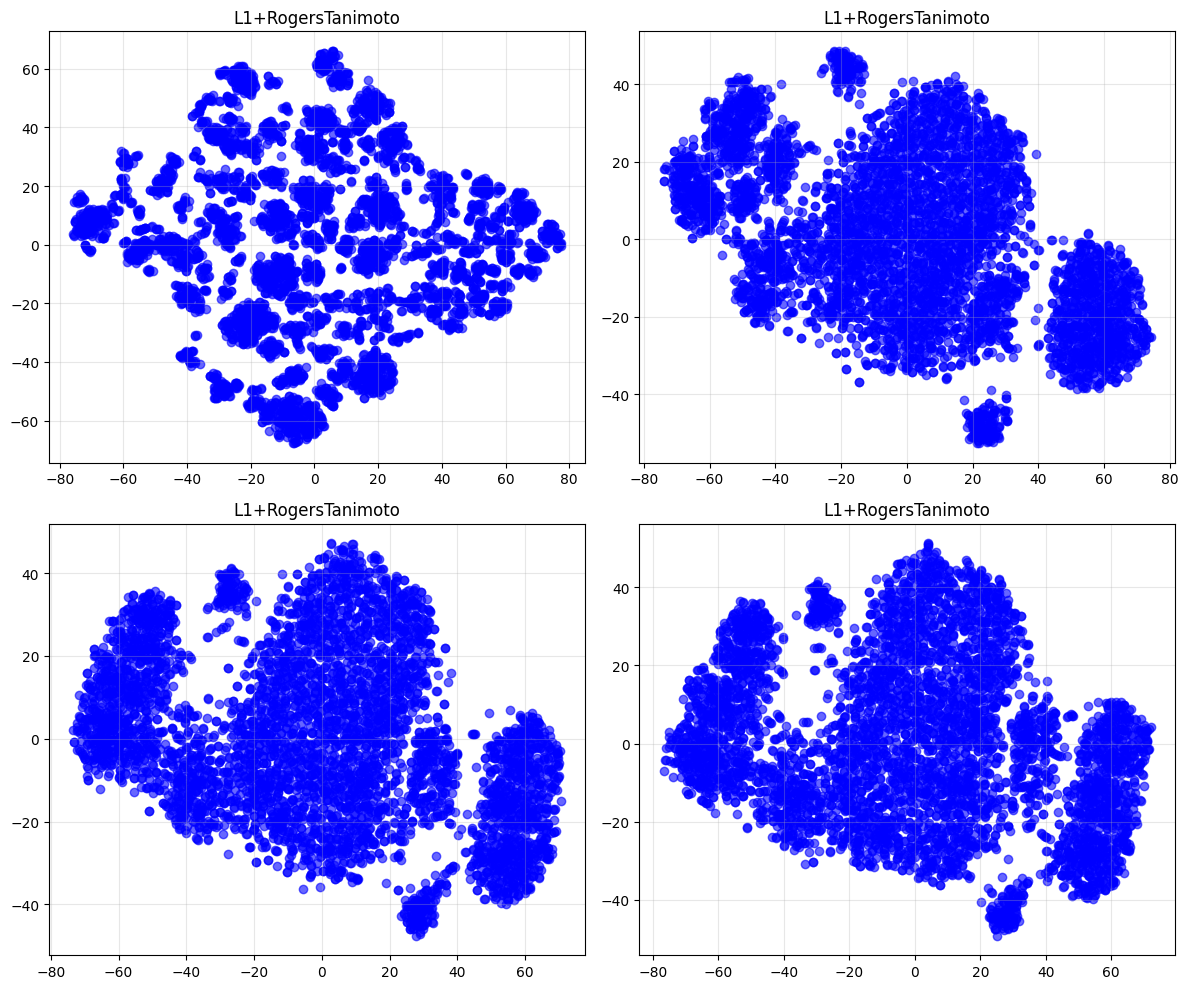

In [13]:
# 2. Custom Distance Weighting

# For reproducibility
random_state = check_random_state(42)

# Let's try different metrics and see what happens
# Create chart
plt.figure(figsize=(12, 10))

weights_vect = np.array([0.2, 0.4, 0.6, 0.8])

for i, w in enumerate(weights_vect):

    # t-SNE with distance = L1+rogerstanimoto
    L1rog_distances = compute_custom_distance(
        X_num,
        X_cat,
        w_num = w,    # Define the weights for the numerical and categorical features
        distance_num = 'cityblock',
        distance_cat = 'rogerstanimoto'
    )
    plot_tsne(L1rog_distances, metric='precomputed', title='L1+RogersTanimoto', subplot_position=i+1)

    # t-SNE, L1 rog, 3-D
    tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random')
    Y_3d = tsne.fit_transform(L1rog_distances)

    # Visualize 3-D
    fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:,1], z=Y_3d[:,2])
    fig.update_traces(marker = dict(size=2))
    fig.update_layout()
    fig.show()

# Show everything
plt.tight_layout()
plt.show()


From now on we focus on the 2 best model from a qualitative perspective, i.e. the weighted gower distance and the combined L1+RogersTanimoto

In [14]:
# compute the Gower distance matrix with custom weights
weights = np.array([8, 7, 10, 10, 10, 9, 7, 10, 8, 7, 10, 10, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]/np.sum(np.array([8, 7, 10, 10, 10, 9, 7, 10, 8, 7, 10, 10, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])))                
gower_distances = gower.gower_matrix(X, weight = weights)

# compute the custom distance matrix with custom weights
L1rog_distances = compute_custom_distance(
    X_num,
    X_cat,
    w_num = 0.6,   # Define the weights for the numerical and categorical features
    distance_num = 'cityblock',
    distance_cat = 'rogerstanimoto'
)

Experimenting with the t-SNE Perplexity Hyperparameter

t-SNE is a powerful technique for dimensionality reduction, but its performance heavily depends on the choice of hyperparameters. One key hyperparameter is perplexity, which roughly represents the number of effective neighbors each data point considers. This parameter plays a crucial role in the resulting embedding and clustering detection, as it balances the focus between local and global data structures.

Instead of using the default perplexity value, we perform a non-linear grid search over a range of values. In this approach, we start with a logarithmically spaced grid to cover a broad range, quickly pinpointing a region where perplexity yields sensible results. Once this promising zone is identified, we refine the search further by increasing the grid density.

Note: t-SNE is computationally intensive, so selecting the grid range and resolution wisely is important to avoid excessive computation times.

In [15]:
def run_tsne(X_data, metric, perplexity):
    """
    Run TSNE on the data with a given metric and perplexity.
    For the 'Gower' metric, we use the precomputed Gower distance matrix.
    """
    if metric == 'Gower':
        tsne = TSNE(perplexity=perplexity, learning_rate='auto', init='random',
                    random_state=random_state, metric='precomputed')
        Y = tsne.fit_transform(gower_distances)
    elif metric == 'L1_RogersTanimoto':
        tsne = TSNE(perplexity=perplexity, learning_rate='auto', init='random',
                    random_state=random_state, metric='precomputed')
        Y = tsne.fit_transform(L1rog_distances)
    else:
        tsne = TSNE(perplexity=perplexity, learning_rate='auto', init='random',
                    random_state=random_state, metric=metric)
        Y = tsne.fit_transform(X_data)
    return Y

Perplexity values to test: [  5   7  10  14  19  27  37  52  73 102 143 200]


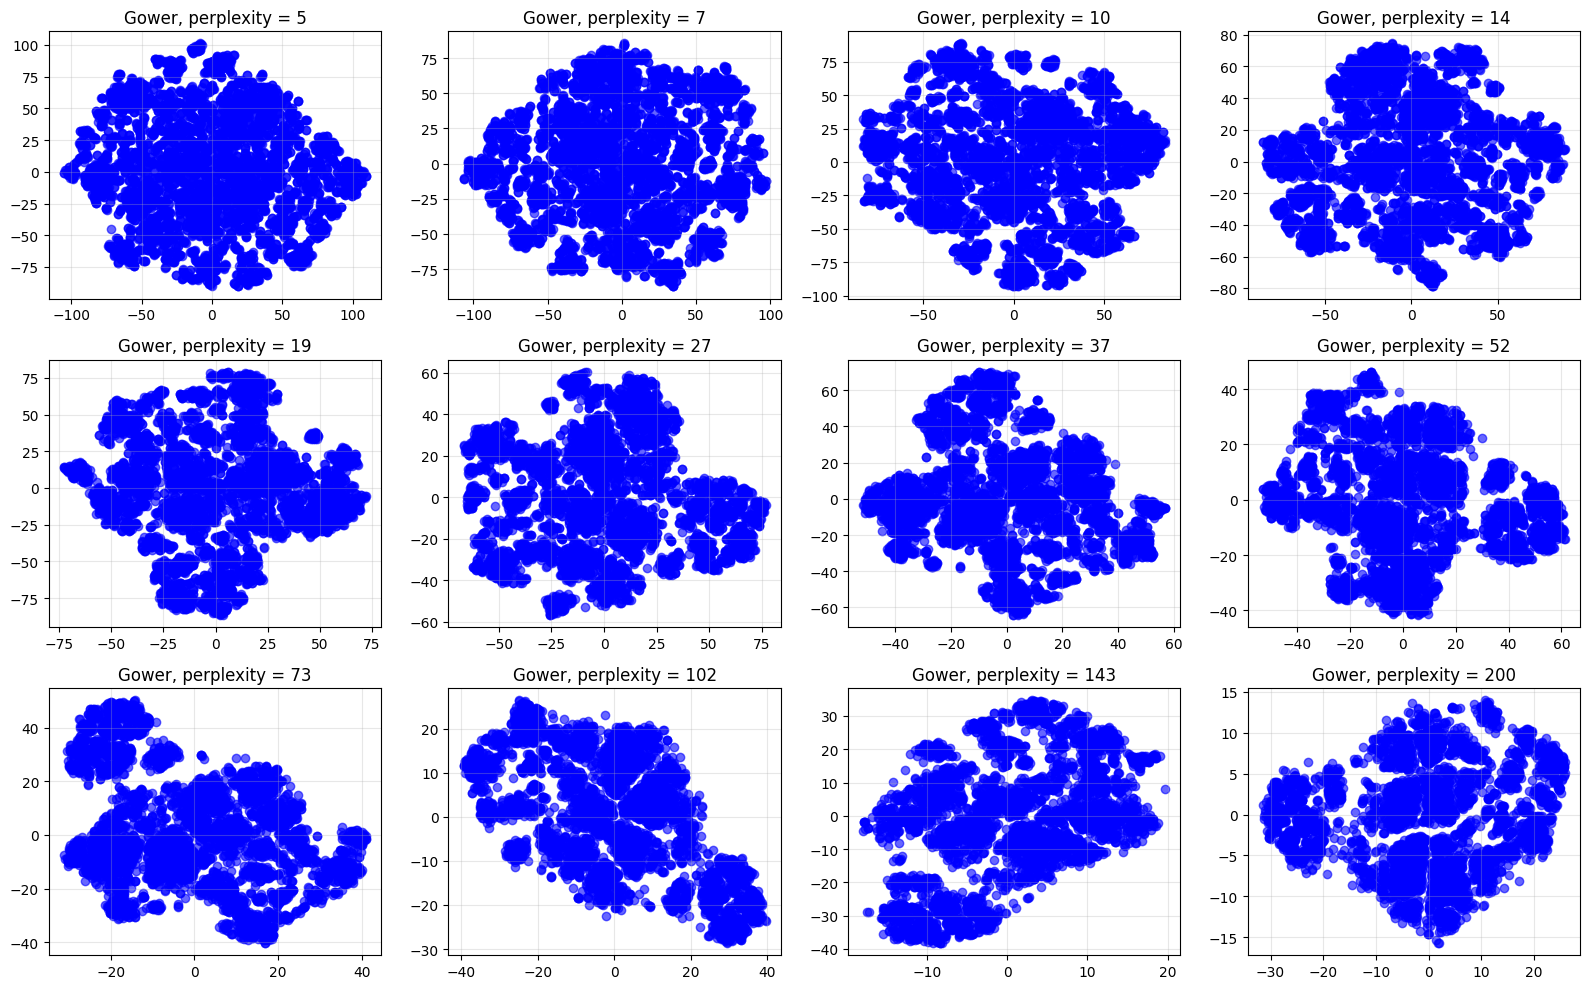

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# import gower
# from sklearn.manifold import TSNE
# from sklearn.utils import check_random_state

# Define the weights and normalize them
# weights = np.array([4, 4, 10, 10, 10, 7, 5, 10, 5, 4, 10, 9, 4, 6, 6, 6, 6, 8, 8, 6, 6, 9, 9])
# weights = weights / np.sum(weights)

# Calculate the Gower distance matrix
# gower_distances = gower.gower_matrix(X, weight=weights)

# For reproducibility
random_state = check_random_state(42)

# Create a non-linear (logarithmic) grid of perplexity values.
# We try values between 5 and 100.
perplexity_values = np.unique(np.round(np.logspace(np.log10(5), np.log10(200), num=12)).astype(int))
print("Perplexity values to test:", perplexity_values)

# Now, let's create a grid of plots for t-SNE with the 'gower' metric
plt.figure(figsize=(16, 10))
for i, perplexity in enumerate(perplexity_values):
    Y = run_tsne(X, metric='Gower', perplexity=perplexity)
    plt.subplot(3, 4, i+1)
    plt.scatter(Y[:, 0], Y[:, 1], c='blue', alpha=0.6)
    plt.title(f'Gower, perplexity = {perplexity}')
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

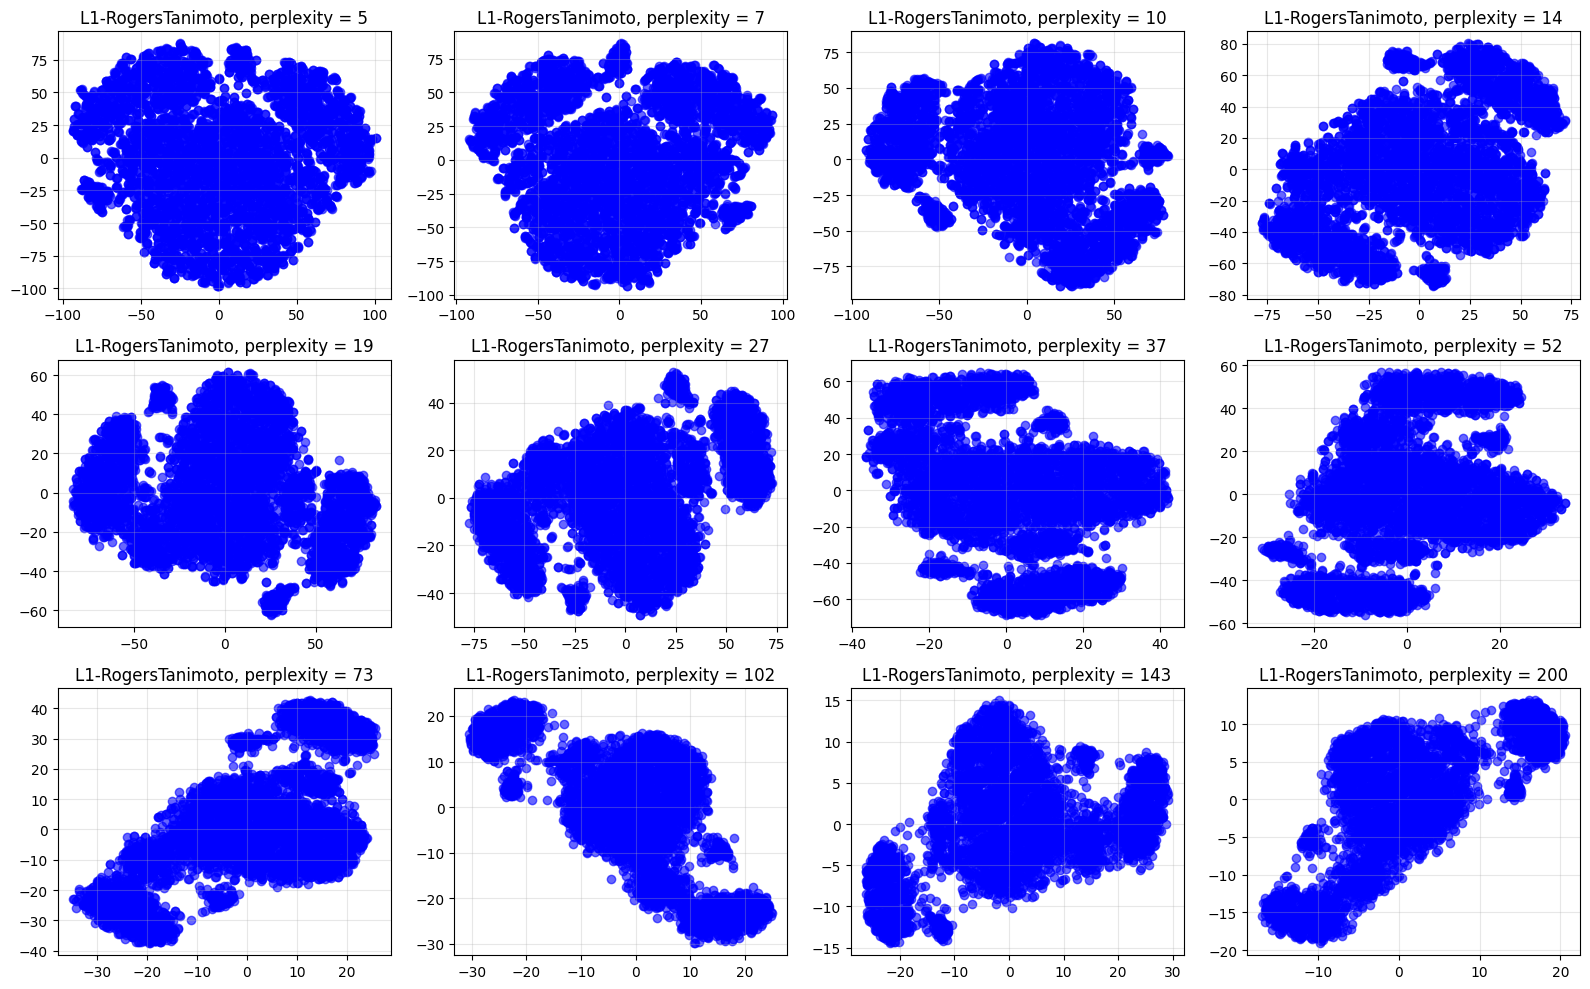

In [17]:
# Now, let's create a grid of plots for t-SNE with the 'L1-RogersTanimoto' metric
plt.figure(figsize=(16, 10))
for i, perplexity in enumerate(perplexity_values):
    Y = run_tsne(X, metric='L1_RogersTanimoto', perplexity=perplexity)
    plt.subplot(3, 4, i+1)
    plt.scatter(Y[:, 0], Y[:, 1], c='blue', alpha=0.6)
    plt.title(f'L1-RogersTanimoto, perplexity = {perplexity}')
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [18]:
import plotly.express as px

gower_perplexity = np.array([37, 73, 102])
L1rog_perplexity = np.array([37, 52, 73])

for i, p in enumerate(gower_perplexity):
    
    # t-SNE, gower, 3-D
    tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random', perplexity=p)
    Y_3d = tsne.fit_transform(gower_distances)
    
    # Visualize 3-D
    fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:,1], z=Y_3d[:,2])
    fig.update_traces(marker = dict(size=2))
    fig.update_layout()
    fig.update_layout(title = f'Gower, perplexity = {p}')
    fig.show()

for i, p in enumerate(L1rog_perplexity):

    # t-SNE, L1_RogersTanimoto, 3-D
    tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random', perplexity=p)
    Y_3d = tsne.fit_transform(L1rog_distances)

    # Visualize 3-D
    fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:,1], z=Y_3d[:,2])
    fig.update_traces(marker = dict(size=2))
    fig.update_layout()
    fig.update_layout(title = f'L1-RogersTanimoto, perplexity = {p}')
    fig.show()

37,52

PCA

Now we try Principal Component Analysis (PCA): we use PCA, another popular dimensionality reduction method, as an alternative exploratory technique to give you a way to visualise the relationships between variables in a lower dimensional space, eventually spotting clusters.

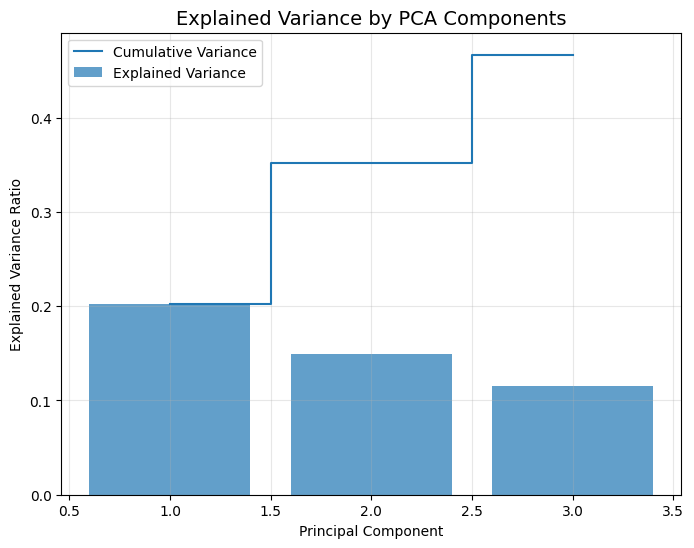

Explained Variance Ratios: [0.20206954 0.1492904  0.11530077]
Cumulative Variance Explained: [0.20206954 0.35135995 0.46666071]


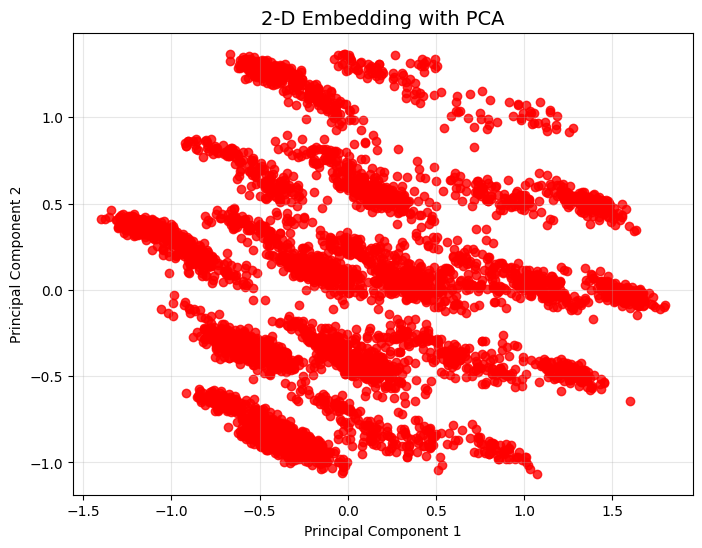

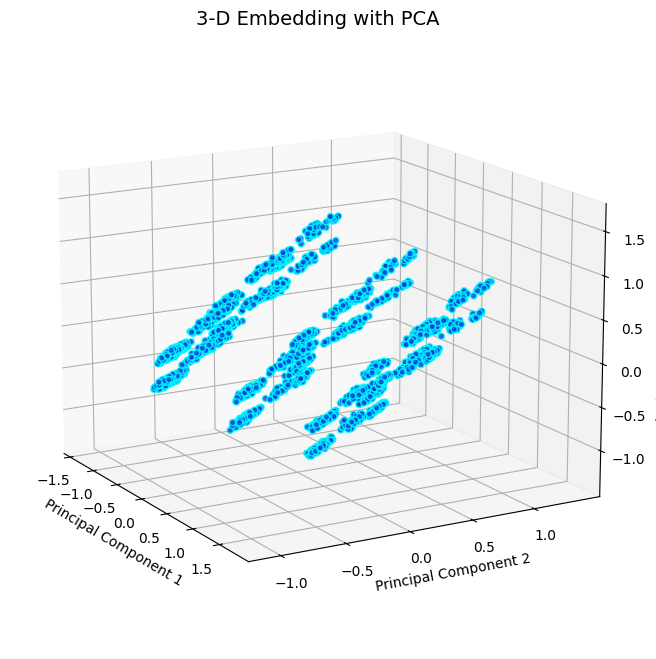

In [19]:
from sklearn.decomposition import PCA
import plotly.express as px

# PCA
pca = PCA(n_components=3)  # 3 PC
X_pca = pca.fit_transform(X)

# Explained variance
plt.figure(figsize=(8, 6))
explained_variance = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Explained Variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative Variance')
plt.title('Explained Variance by PCA Components', fontsize=14)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

# Explained variance by each PCA Component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

# Cumulative variance explained
print("Cumulative Variance Explained:", np.cumsum(explained_variance))


# 2D Embedding
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='red', alpha=0.8)
plt.title('2-D Embedding with PCA', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, alpha=0.3)
plt.show()


# 3D Embedding (Matplotlib)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# # 3D Scatter
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
            edgecolor='cyan', facecolor=(0, 0.25, 0.85), alpha=0.8)

ax.set_title('3-D Embedding with PCA', fontsize=14)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.view_init(elev=15, azim=-30)

plt.show()


# Alternative 3D Embedding (plotly)
# Visualize 3-D
fig = px.scatter_3d(x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2])
fig.update_traces(marker = dict(size=2))
fig.update_layout(title = '3-D Embedding with PCA')
fig.show()



Application of FastICA

FastICA (Fast Independent Component Analysis) is a method in sklearn.decomposition used for blind source separation and dimensionality reduction. It aims to extract independent components from mixed signals by assuming that the observed data are linear mixtures of independent, non-Gaussian sources.

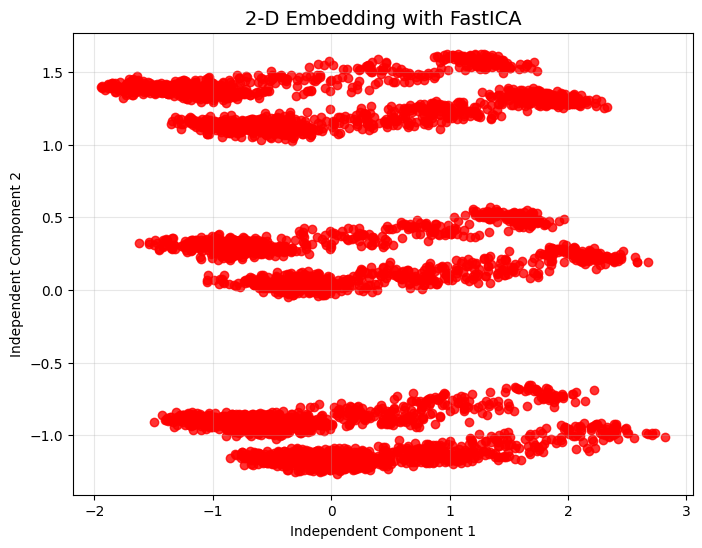

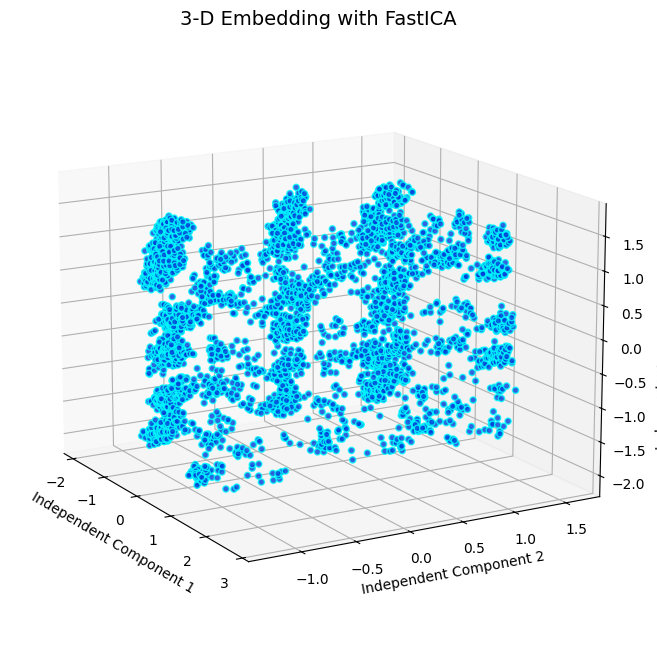

In [20]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# FastICA
ica = FastICA(n_components=3, random_state=42)  # 3 Independent Components
X_ica = ica.fit_transform(X)

# 2D Embedding
plt.figure(figsize=(8, 6))
plt.scatter(X_ica[:, 0], X_ica[:, 1], color='red', alpha=0.8)
plt.title('2-D Embedding with FastICA', fontsize=14)
plt.xlabel('Independent Component 1')
plt.ylabel('Independent Component 2')
plt.grid(True, alpha=0.3)
plt.show()

# 3D Embedding (Matplotlib)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ica[:, 0], X_ica[:, 1], X_ica[:, 2],
            edgecolor='cyan', facecolor=(0, 0.25, 0.85), alpha=0.8)

ax.set_title('3-D Embedding with FastICA', fontsize=14)
ax.set_xlabel('Independent Component 1')
ax.set_ylabel('Independent Component 2')
ax.set_zlabel('Independent Component 3')
ax.view_init(elev=15, azim=-30)

plt.show()

# Alternative 3D Embedding (Plotly)
# Visualize 3-D
fig = px.scatter_3d(x=X_ica[:, 0], y=X_ica[:, 1], z=X_ica[:, 2])
fig.update_traces(marker = dict(size=2))
fig.update_layout(title = '3-D Embedding with FastICA')
fig.show()




Application of FactorAnalysis

FactorAnalysis is a dimensionality reduction technique available in scikit-learn that models the observed data as a linear combination of latent factors and noise. It is similar to Principal Component Analysis (PCA), but with the key difference that it explicitly models noise separately from the latent factors.

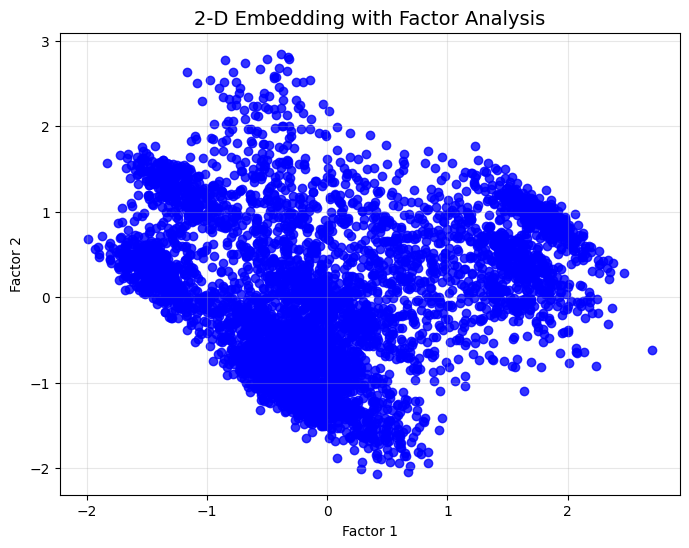

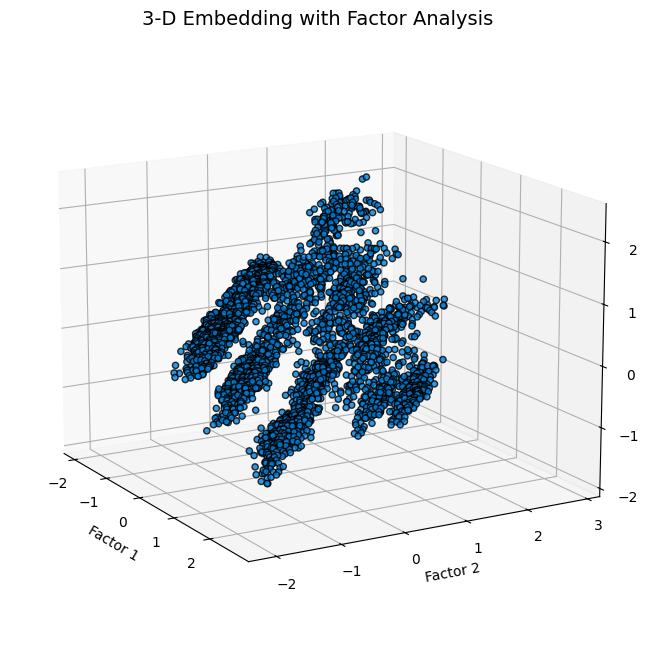

In [21]:
from sklearn.decomposition import FactorAnalysis
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Apply Factor Analysis
fa = FactorAnalysis(n_components=3, random_state=42)  # Extract 3 latent factors
X_fa = fa.fit_transform(X)

# 2D Embedding
plt.figure(figsize=(8, 6))
plt.scatter(X_fa[:, 0], X_fa[:, 1], color='blue', alpha=0.8)
plt.title('2-D Embedding with Factor Analysis', fontsize=14)
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.grid(True, alpha=0.3)
plt.show()

# 3D Embedding (Matplotlib)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_fa[:, 0], X_fa[:, 1], X_fa[:, 2], edgecolor='black', facecolor=(0, 0.5, 0.85), alpha=0.8)

ax.set_title('3-D Embedding with Factor Analysis', fontsize=14)
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.view_init(elev=15, azim=-30)

plt.show()

# Alternative 3D Embedding (Plotly)
fig = px.scatter_3d(x=X_fa[:, 0], y=X_fa[:, 1], z=X_fa[:, 2], 
                     title='3-D Embedding with Factor Analysis')
fig.update_traces(marker=dict(size=2))
fig.show()

Clustering in action

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids

def perform_kmedoids_clustering(Y_3d, k, distances_matrix):
    """
    Perform K-medoids clustering and return the labels.
    """
    kmedoids = KMedoids(
        n_clusters=k,
        metric='precomputed',
        random_state=42,
        init='k-medoids++',
        max_iter=300
    )
    labels = kmedoids.fit_predict(distances_matrix)
    return labels

def plot_kmedoids_clusters(Y_3d_dict, cluster_results):
    """
    Create a 2x2 subplot for the 3D visualization of different k values.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    colors = ['blue', '#4DBEEE', '#77AC30', '#EDB120', '#D95319', '#7E2F8E']
    
    for i, k in enumerate(cluster_results.keys()):
        ax = axes[i]
        labels = cluster_results[k]
        Y_3d = Y_3d_dict[k]
        
        for j in range(k):
            mask = labels == j
            ax.scatter(Y_3d[mask, 0], Y_3d[mask, 1], Y_3d[mask, 2],
                       edgecolor='k', facecolor=colors[j], alpha=0.8, label=f'Cluster {j+1}')
        
        ax.set_title(f'3D Embedding of {k} clusters')
        ax.legend()
        ax.view_init(elev=15, azim=-30)
    
    plt.tight_layout()
    plt.show()


def plot_kmedoids_clusters_plotly(Y_3d_dict, cluster_results):
    """
    Create interactive 3D scatter plots using Plotly.
    """
    for k in cluster_results.keys():
        labels = cluster_results[k]
        Y_3d = Y_3d_dict[k]
        
        fig = px.scatter_3d(x=Y_3d[:, 0], y=Y_3d[:, 1], z=Y_3d[:, 2], color=labels)
        fig.update_traces(marker=dict(size=2.5))
        fig.update_layout(title_text=f'3D Scatter Plot of {k} Clusters', width=1200, height=600)
        fig.show()

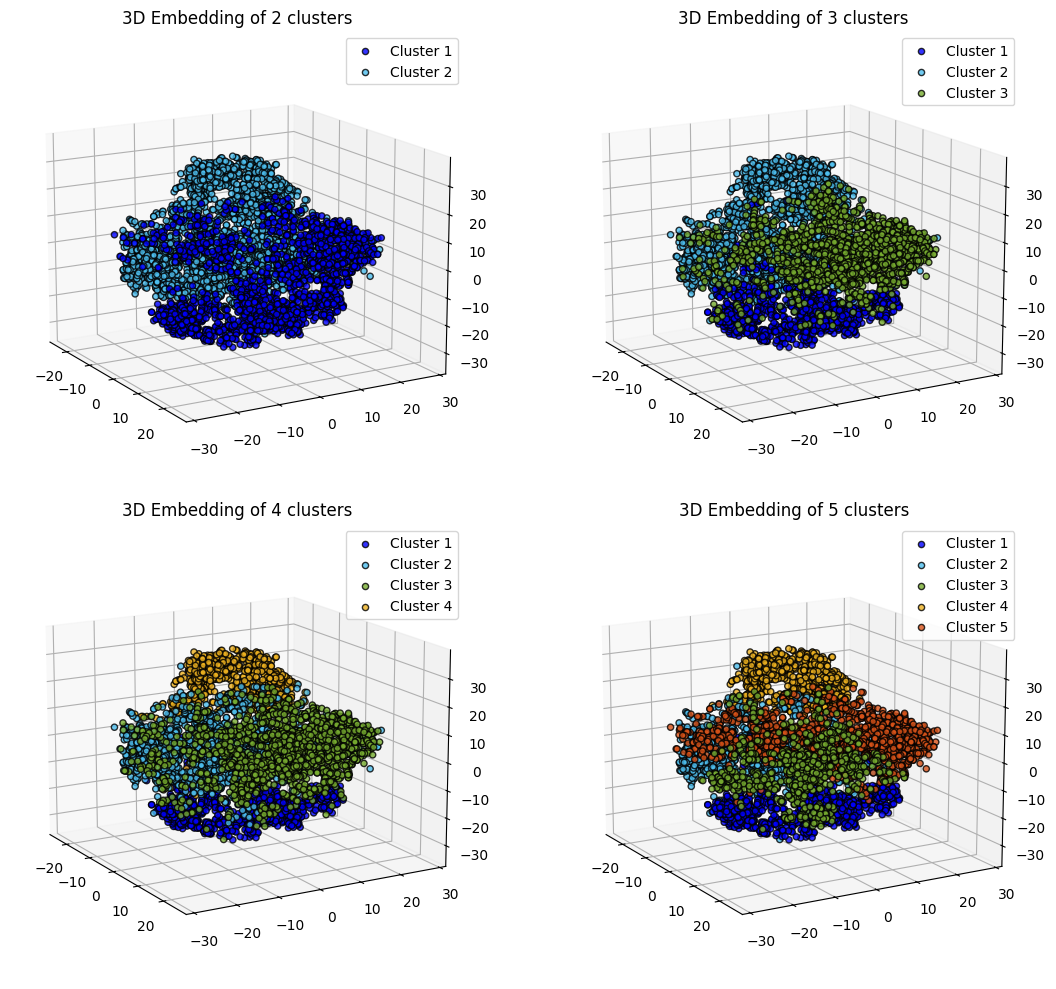

In [55]:
# Main execution
k_values = [2, 3, 4, 5]
cluster_results_gower = {}
Y_3d_dict = {}

# t-SNE, Gower, 3-D
tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random', perplexity=37)
Y_3d_gower = tsne.fit_transform(gower_distances)

for k in k_values:
    labels = perform_kmedoids_clustering(Y_3d_gower, k, gower_distances)
    cluster_results_gower[k] = labels
    Y_3d_dict[k] = Y_3d_gower  # Store the same embedding for consistency

plot_kmedoids_clusters(Y_3d_dict, cluster_results_gower)
plot_kmedoids_clusters_plotly(Y_3d_dict, cluster_results_gower)

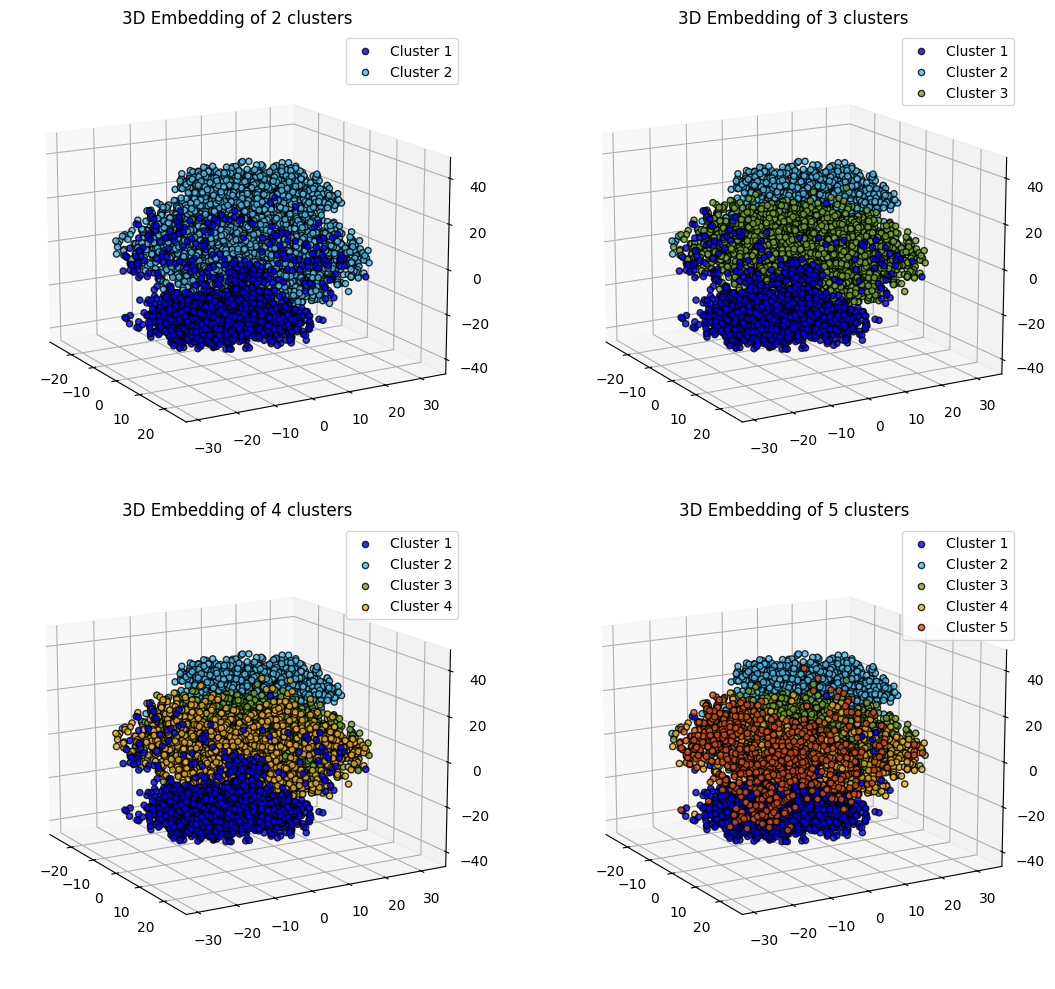

In [56]:
# Main execution
k_values = [2, 3, 4, 5]
cluster_results_L1rog = {}
Y_3d_dict = {}

# t-SNE, L1+RogersTanimoto, 3-D
tsne = TSNE(n_components=3, metric='precomputed', random_state=42, init='random', perplexity=52)
Y_3d_custom = tsne.fit_transform(L1rog_distances)

for k in k_values:
    labels = perform_kmedoids_clustering(Y_3d_custom, k, L1rog_distances)
    cluster_results_L1rog[k] = labels
    Y_3d_dict[k] = Y_3d_custom  # Store the same embedding for consistency

plot_kmedoids_clusters(Y_3d_dict, cluster_results_L1rog)
plot_kmedoids_clusters_plotly(Y_3d_dict, cluster_results_L1rog)

# Clustering Evaluation

We have performed the k-medoids clustering with different k values and with two different distances, and we proceed by evaluating the quality of our clustering solutions.

The evaluation will be both **qualitative** and **quantitative**.

In order to quantitatively evaluate our clusters, we'll use three widely-recognized clustering validation metrics:

## Evaluation Metrics

1. **[Calinski-Harabasz Index](https://en.wikipedia.org/wiki/Calinski%E2%80%93Harabasz_index)**
   - Measures the ratio of between-cluster dispersion to within-cluster dispersion.
   - Higher values indicate better clustering.
   - Best for well-separated, globular clusters.
   
2. **[Davies-Bouldin Index](https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index)**
   - Measures the average similarity between each cluster and its most similar one.
   - Lower values indicate better clustering.
   - Particularly useful when clusters are convex and well-separated.

3. **[Silhouette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering))**
   - Measures how similar an object is to its own cluster compared to other clusters.
   - Range: [-1, 1] where:
     - 1: Points are well matched to their clusters.
     - 0: Points are on the decision boundary.
     - -1: Points might be assigned to wrong clusters.
   - Works well with Gower distance for mixed data types.

## Visualization
The code produces three plots showing how each metric varies with the number of clusters (k). This helps **identify the optimal number of clusters** according to different criteria.

<br>


In [57]:
# Clustering evaluation
def evaluate_clustering(X, cluster_results, distances_matrix):
    k_values = list(cluster_results.keys())

    # Initialize metrics
    ch_scores = []
    db_scores = []
    sil_scores = []

    # Calculate metrics for each k
    for k in k_values:
        labels = cluster_results[k]
        ch_scores.append(calinski_harabasz_score(X, labels))
        db_scores.append(davies_bouldin_score(X, labels))
        sil_scores.append(silhouette_score(distances_matrix, labels, metric='precomputed'))

    # Plot evaluation metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Calinski-Harabasz
    ax1.plot(k_values, ch_scores, 'bo-')
    ax1.set_title('Calinski-Harabasz score')
    ax1.set_xlabel('Number of clusters')
    ax1.grid(True)

    # Davies-Bouldin
    ax2.plot(k_values, db_scores, 'ro-')
    ax2.set_title('Davies-Bouldin score')
    ax2.set_xlabel('Number of clusters')
    ax2.grid(True)

    # Silhouette
    ax3.plot(k_values, sil_scores, 'go-')
    ax3.set_title('Silhouette score')
    ax3.set_xlabel('Number of clusters')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    # Print optimal values
    print(f"Optimal k according to Calinski-Harabasz: {k_values[np.argmax(ch_scores)]}")
    print(f"Optimal k according to Davies-Bouldin: {k_values[np.argmin(db_scores)]}")
    print(f"Optimal k according to Silhouette: {k_values[np.argmax(sil_scores)]}")

    return ch_scores, db_scores, sil_scores



Gower Distance:


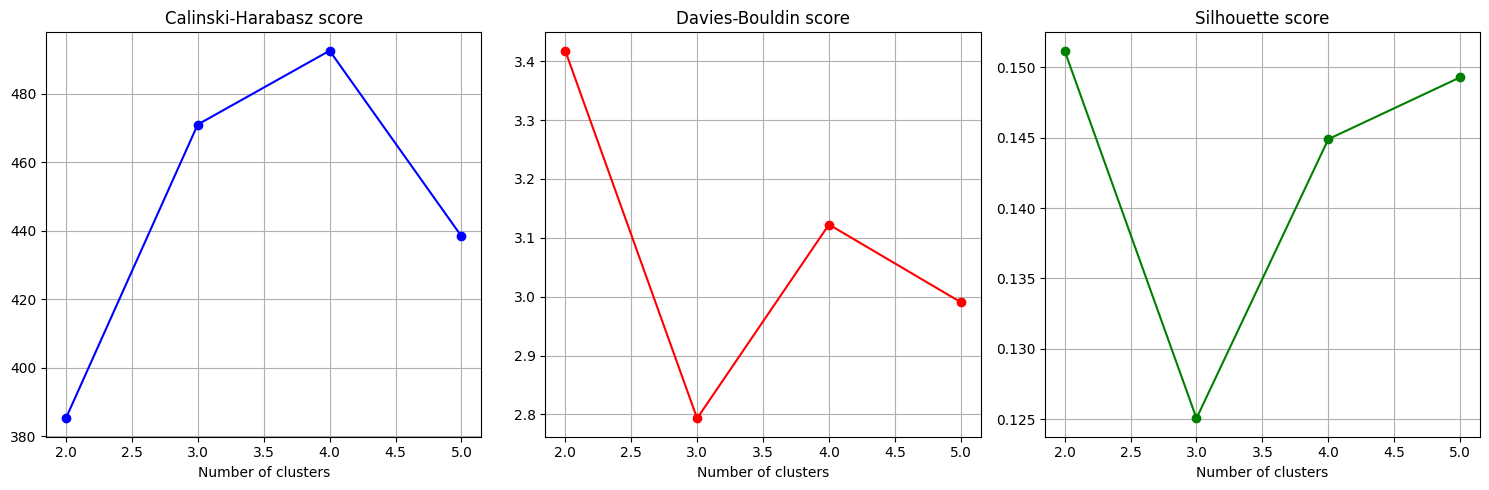

Optimal k according to Calinski-Harabasz: 4
Optimal k according to Davies-Bouldin: 3
Optimal k according to Silhouette: 2

L1+RogersTanimoto Distance:


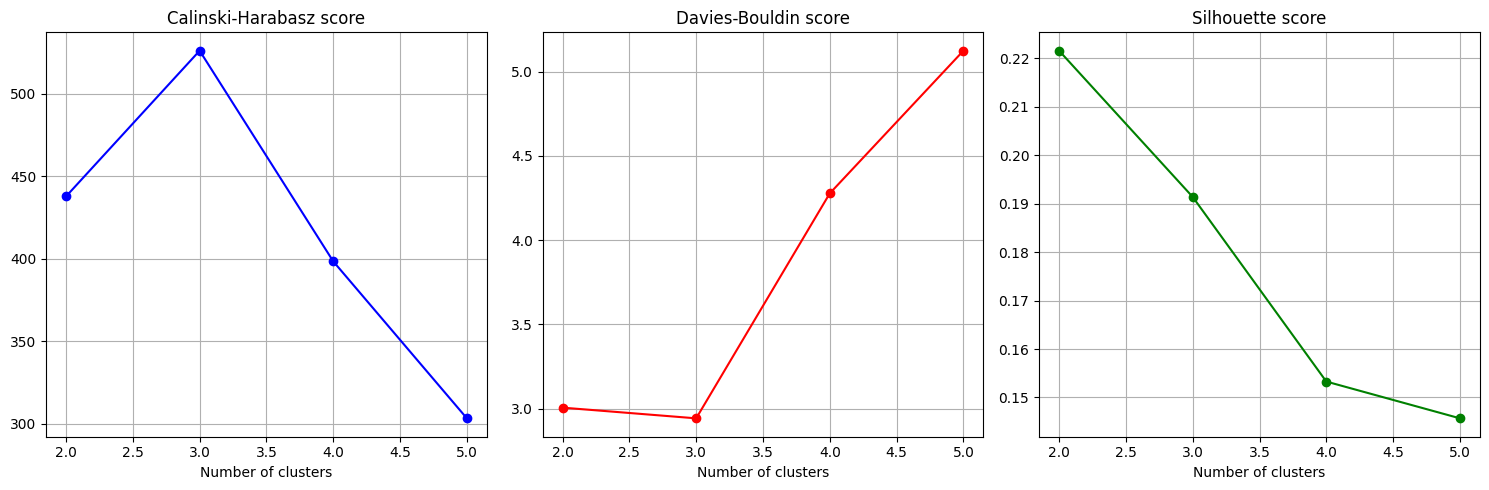

Optimal k according to Calinski-Harabasz: 3
Optimal k according to Davies-Bouldin: 3
Optimal k according to Silhouette: 2


In [58]:
# Evaluate clustering results via Gower distance
print("Gower Distance:")
ch_scores_gower, db_scores_gower, sil_scores_gower = evaluate_clustering(X, cluster_results_gower, gower_distances)

# Evaluate clustering results via L1+RogersTanimoto distance
print("\nL1+RogersTanimoto Distance:")
ch_scores_L1rog, db_scores_L1rog, sil_scores_L1rog = evaluate_clustering(X, cluster_results_L1rog, L1rog_distances)

## Cluster number selection through voting

As explained in the given code and as can be observed above, one clustering may be better than another by one metric, and the reverse may be true using another metric. Luckily, in clustering there is often no one "correct answer".

So we implement a **robust voting scheme** to determine the optimal number of clusters by:
1. Collecting recommendations from three different validation metrics.
2. Taking their median value as the final decision.

This approach:
- Balances different evaluation perspectives.
- Provides stability against outlier recommendations.
- Reduces the impact of individual metric biases.

The final number of clusters represents a consensus among:
- Calinski-Harabasz Index.
- Davies-Bouldin Index.
- Silhouette Score.

<br>


In [59]:
def get_optimal_k_voting(X, cluster_results, distances_matrix):
    k_values = list(cluster_results.keys())

    # Compute scores first
    ch_scores = [calinski_harabasz_score(X, cluster_results[k]) for k in k_values]
    db_scores = [davies_bouldin_score(X, cluster_results[k]) for k in k_values]
    sil_scores = [silhouette_score(distances_matrix, cluster_results[k], metric='precomputed') for k in k_values]

    # Get optimal k for each metric
    ch_optimal = k_values[np.argmax(ch_scores)]
    db_optimal = k_values[np.argmin(db_scores)]
    sil_optimal = k_values[np.argmax(sil_scores)]

    # Get median k
    optimal_k = int(np.median([ch_optimal, db_optimal, sil_optimal]))

    # Print results
    print("\nVoting Results:")
    print(f"Calinski-Harabasz suggests: {ch_optimal} clusters")
    print(f"Davies-Bouldin suggests: {db_optimal} clusters")
    print(f"Silhouette suggests: {sil_optimal} clusters")
    print(f"\nFinal decision (median): {optimal_k} clusters")

    return optimal_k


In [60]:
# Get the optimal k through robust voting in the Gower distance case
final_k_gower = get_optimal_k_voting(X, cluster_results_gower, gower_distances)

# Get the optimal k through robust voting in the L1+RogersTanimoto distance case
final_k_L1rog = get_optimal_k_voting(X, cluster_results_L1rog, L1rog_distances)



Voting Results:
Calinski-Harabasz suggests: 4 clusters
Davies-Bouldin suggests: 3 clusters
Silhouette suggests: 2 clusters

Final decision (median): 3 clusters

Voting Results:
Calinski-Harabasz suggests: 3 clusters
Davies-Bouldin suggests: 3 clusters
Silhouette suggests: 2 clusters

Final decision (median): 3 clusters


# DBSCAN

Let's try another clustering technique (there are tons of them): **[DBSCAN (Density-Based Spatial Clustering of Applications with Noise)](https://en.wikipedia.org/wiki/DBSCAN)**, which might offer several advantages for our bank client segmentation. DBSCAN is one of the most commonly used clustering algorithms, and for a good reason.

## Key Features

1. **Automatic Cluster Detection**
   - Discovers clusters naturally present in the data.
   - **No need to specify number of clusters beforehand**.
   - Lets the data structure guide the clustering process.

2. **Density-Based Approach**
   - Discovers clusters of arbitrary shape
   - Naturally handles outliers by marking them as noise points
   - Forms clusters based on density connectivity

3. **Implementation with Gower Distance (or other distances you like)**
   - Uses our pre-computed Gower distance matrix.
   - Might cope well with our mixed-type data (numerical and categorical).
   - Maintains proper distance relationships between observations.

## Parameters

The algorithm requires **two main hyperparameters**:
- **eps (ε)**: Maximum distance between two points to be considered neighbors.
- **min_samples**: Minimum number of points required to form a dense region.

## Evaluation Strategy

We evaluate multiple eps values (i.e. doing some work for hyperparameter tuning) while keeping min_samples constant to:
- Find optimal density parameters.
- Identify natural groupings in the data.
- Balance between noise points and cluster formation.

## Visualization

- 3D cluster visualizations for each eps value.
- Analysis of number of clusters vs eps.
- Distribution of noise points across different parameters.

Thus, this implementation helps identify natural customer segments while isolating unusual cases as noise points.

<br>

In [ ]:
# DBSCAN Clustering with generical distance
from sklearn.cluster import DBSCAN

min_samples = 20  # Minimum number of samples in a cluster


# Function to perform DBSCAN clustering with different epsilon values
def perform_dbscan_clustering(distances,Y_3d, eps_values, min_samples):
    results = {}

    for eps in eps_values:
        # Initialize and fit DBSCAN
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='precomputed'
        )

        # Fit using Gower distances
        labels = dbscan.fit_predict(distances)

        # Store results
        results[eps] = {
            'labels': labels,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
            'n_noise': list(labels).count(-1)
        }

        # Visualize clusters in 3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot noise points
        noise_mask = labels == -1
        ax.scatter(Y_3d[noise_mask, 0],
                    Y_3d[noise_mask, 1],
                    Y_3d[noise_mask, 2],
                    c='gray', marker='x', label='Noise')

        # Plot clusters
        colors = plt.cm.rainbow(np.linspace(0, 1, results[eps]['n_clusters']))
        for i, color in enumerate(colors):
            mask = labels == i
            ax.scatter(Y_3d[mask, 0],
                        Y_3d[mask, 1],
                        Y_3d[mask, 2],
                        c=[color], label=f'Cluster {i}')

        ax.set_title(f'DBSCAN clustering (eps={eps:.3f})')
        ax.legend()
        plt.show()

        # Calculate silhouette score if more than one cluster and no noise points
        if results[eps]['n_clusters'] > 1 and results[eps]['n_noise'] == 0:
            sil_score = silhouette_score(distances, labels, metric='precomputed')
            results[eps]['silhouette'] = sil_score
        else:
            results[eps]['silhouette'] = None

        print(f"\nEpsilon: {eps:.3f}")
        print(f"Number of clusters: {results[eps]['n_clusters']}")
        print(f"Number of noise points: {results[eps]['n_noise']}")
        print(f"Silhouette score: {results[eps]['silhouette']}")

    return results


### KNN

how to find the "correct" eps

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Assume data_scaled is your preprocessed and scaled dataset
# For example, if using DBSCAN, you might set min_samples = 4
k = min_samples # you can change this to match your DBSCAN parameter (min_samples)

# Compute the k-nearest neighbors distances for each data point
nbrs = NearestNeighbors(n_neighbors=k,metric='precomputed').fit(gower_distances)
distances, indices = nbrs.kneighbors(gower_distances)

# Extract the distance to the kth nearest neighbor for each point
# (kth nearest neighbor is at index k-1 because of zero indexing)
kth_distances = distances[:, k - 1]

# Sort the distances in ascending order
kth_distances_sorted = np.sort(kth_distances)

# Plot the sorted kth nearest neighbor distances
plt.figure(figsize=(8, 5))
plt.plot(kth_distances_sorted)
plt.xlabel('Points (sorted)')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.title('KNN Distance Plot')
plt.show()

Custom

In [ ]:

# Assume data_scaled is your preprocessed and scaled dataset
# For example, if using DBSCAN, you might set min_samples = 4
k = 3 # you can change this to match your DBSCAN parameter (min_samples)

# Compute the k-nearest neighbors distances for each data point
nbrs = NearestNeighbors(n_neighbors=k,metric='precomputed').fit(L1rog_distances)
distances, indices = nbrs.kneighbors(L1rog_distances)

# Extract the distance to the kth nearest neighbor for each point
# (kth nearest neighbor is at index k-1 because of zero indexing)
kth_distances = distances[:, k - 1]

# Sort the distances in ascending order
kth_distances_sorted = np.sort(kth_distances)

# Plot the sorted kth nearest neighbor distances
plt.figure(figsize=(8, 5))
plt.plot(kth_distances_sorted)
plt.xlabel('Points (sorted)')
plt.ylabel(f'Distance to {k}th Nearest Neighbor')
plt.title('KNN Distance Plot')
plt.show()

### Gower

In [ ]:

# Define epsilon values to try
eps_values = np.linspace(0.05, 0.1, 10)

# Run DBSCAN with different epsilon values
dbscan_results = perform_dbscan_clustering(gower_distances, Y_3d_gower, eps_values, min_samples)

# Plot summary of results
plt.figure(figsize=(12, 5))

# Number of clusters vs epsilon
plt.subplot(1, 2, 1)
eps_list = list(dbscan_results.keys())
n_clusters = [res['n_clusters'] for res in dbscan_results.values()]
plt.plot(eps_list, n_clusters, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Number of clusters')
plt.title('Number of clusters vs epsilon')
plt.grid(True)

# Noise points vs epsilon
plt.subplot(1, 2, 2)
n_noise = [res['n_noise'] for res in dbscan_results.values()]
plt.plot(eps_list, n_noise, 'ro-')
plt.xlabel('Epsilon')
plt.ylabel('Number of noise points')
plt.title('Noise points vs epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()


### Custom distance

In [ ]:

# Define epsilon values to try
eps_values = np.linspace(0.6,0.8,10)

# Run DBSCAN with different epsilon values
dbscan_results = perform_dbscan_clustering(L1rog_distances, Y_3d_custom, eps_values, min_samples)

# Plot summary of results
plt.figure(figsize=(12, 5))

# Number of clusters vs epsilon
plt.subplot(1, 2, 1)
eps_list = list(dbscan_results.keys())
n_clusters = [res['n_clusters'] for res in dbscan_results.values()]
plt.plot(eps_list, n_clusters, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Number of clusters')
plt.title('Number of clusters vs epsilon')
plt.grid(True)

# Noise points vs epsilon
plt.subplot(1, 2, 2)
n_noise = [res['n_noise'] for res in dbscan_results.values()]
plt.plot(eps_list, n_noise, 'ro-')
plt.xlabel('Epsilon')
plt.ylabel('Number of noise points')
plt.title('Noise points vs epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()
